In [1]:
# This cell is for development only. Don't copy this to your notebook.
%load_ext autoreload
%autoreload 2
import anndata

anndata.logging.anndata_logger.addFilter( 
    lambda r: not r.getMessage().startswith("storing")
    and r.getMessage().endswith("as categorical.")
)

# Temporarily suppress FutureWarnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import scirpy as ir
import scanpy as sc
import muon as mu
from glob import glob
import pandas as pd
import tarfile
import anndata
import warnings
import matplotlib.pyplot as plt

sc.set_figure_params(figsize=(4, 4))
sc.settings.verbosity = 2  # verbosity: errors (0), warnings (1), info (2), hints (3)

C:\hostedtoolcache\windows\Python\3.9.13\x64\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load the TCR data
adata_tcr = ir.io.read_10x_vdj(
    "example_data/liao-2019-covid19/GSM4385993_C144_filtered_contig_annotations.csv.gz"
)

# Load the associated transcriptomics data
adata = sc.read_10x_h5(
    "example_data/liao-2019-covid19/GSM4339772_C144_filtered_feature_bc_matrix.h5"
)
adata.var_names_make_unique()

reading example_data/liao-2019-covid19/GSM4339772_C144_filtered_feature_bc_matrix.h5


 (0:00:00)


C:\hostedtoolcache\windows\Python\3.9.13\x64\lib\site-packages\anndata\_core\aligned_mapping.py:54: ExperimentalFeatureWarning: Support for Awkward Arrays is currently experimental. Behavior may change in the future. Please report any issues you may encounter!
  warnings.warn(
C:\hostedtoolcache\windows\Python\3.9.13\x64\lib\site-packages\anndata\_core\anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


This particular sample only has a detected TCR for a small fraction of the cells:

In [4]:
adata_tcr.shape

(136, 0)

In [5]:
adata.shape

(3716, 33539)

In [6]:
mdata = mu.MuData({"gex": adata, "airr": adata_tcr})

Now, we can use TCR-related variables together with the gene expression data.
Here, we visualize the cells with a detected TCR on the UMAP plot.
It is reassuring that the TCRs coincide with the T-cell marker gene CD3.

In [7]:
sc.pp.log1p(mdata["gex"])
sc.pp.pca(mdata["gex"], svd_solver="arpack")
sc.pp.neighbors(mdata["gex"])
sc.tl.umap(mdata["gex"])

computing PCA


    with n_comps=50


    finished (0:00:02)


computing neighbors


    using 'X_pca' with n_pcs = 50


    finished (0:00:04)


computing UMAP


    finished (0:00:09)


In [8]:
ir.pp.index_chains(mdata)
ir.tl.chain_qc(mdata)

  0%|          | 0/136 [00:00<?, ?it/s]

 46%|████▋     | 63/136 [00:00<00:00, 576.03it/s]

 98%|█████████▊| 133/136 [00:00<00:00, 613.64it/s]

100%|██████████| 136/136 [00:00<00:00, 621.72it/s]

Stored result in `mdata.obs["airr:receptor_type"]`.


Stored result in `mdata.obs["airr:receptor_subtype"]`.


Stored result in `mdata.obs["airr:chain_pairing"]`.


C:\hostedtoolcache\windows\Python\3.9.13\x64\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


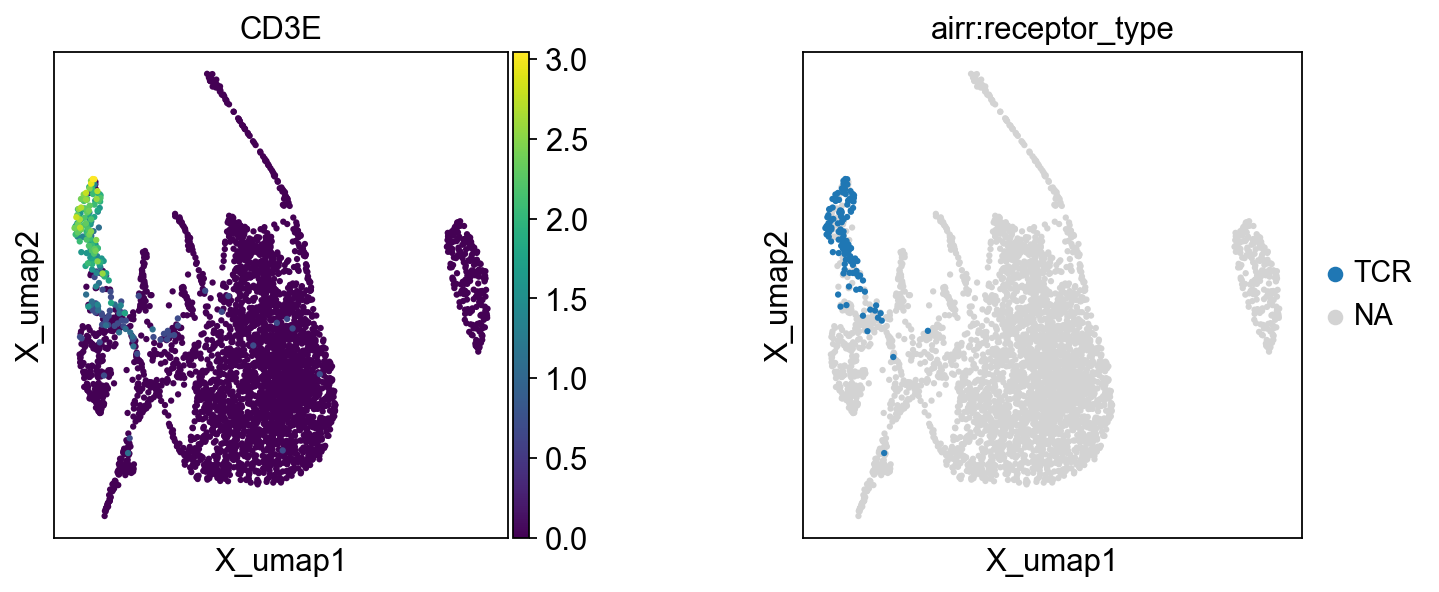

In [9]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={"wspace": 0.5})
mu.pl.embedding(mdata, basis="gex:umap", color=["CD3E"], ax=ax0, show=False)
mu.pl.embedding(mdata, basis="gex:umap", color=["airr:receptor_type"], ax=ax1)

In [10]:
# extract data
with tarfile.open("example_data/chung-park-2017.tar.bz2", "r:bz2") as tar:
    tar.extractall("example_data/chung-park-2017")

First, we load the transcriptomics data from the `counts.tsv` file: 

In [11]:
expr_chung = pd.read_csv("example_data/chung-park-2017/counts.tsv", sep="\t")
# anndata needs genes in columns and samples in rows
expr_chung = expr_chung.set_index("Geneid").T
adata = sc.AnnData(expr_chung)
adata.shape

(563, 23438)

In [12]:
adata_tcr = ir.io.read_tracer("example_data/chung-park-2017/tracer/")
mdata = mu.MuData({"gex": adata, "airr": adata_tcr})

In [13]:
sc.pp.highly_variable_genes(mdata["gex"], flavor="cell_ranger", n_top_genes=3000)
sc.pp.log1p(mdata["gex"])
sc.pp.pca(mdata["gex"], svd_solver="arpack")
sc.pp.neighbors(mdata["gex"])
sc.tl.umap(mdata["gex"])
ir.pp.index_chains(mdata)
ir.tl.chain_qc(mdata)

If you pass `n_top_genes`, all cutoffs are ignored.


extracting highly variable genes


    finished (0:00:00)


computing PCA


    on highly variable genes


    with n_comps=50


    finished (0:00:00)


computing neighbors


    using 'X_pca' with n_pcs = 50


    finished (0:00:00)


computing UMAP


    finished (0:00:02)


  0%|          | 0/563 [00:00<?, ?it/s]

 18%|█▊        | 102/563 [00:00<00:00, 931.96it/s]

 37%|███▋      | 207/563 [00:00<00:00, 948.42it/s]

 74%|███████▎  | 415/563 [00:00<00:00, 1383.66it/s]

 98%|█████████▊| 554/563 [00:00<00:00, 1266.15it/s]

100%|██████████| 563/563 [00:00<00:00, 1200.18it/s]

Stored result in `mdata.obs["airr:receptor_type"]`.


Stored result in `mdata.obs["airr:receptor_subtype"]`.


Stored result in `mdata.obs["airr:chain_pairing"]`.


C:\hostedtoolcache\windows\Python\3.9.13\x64\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


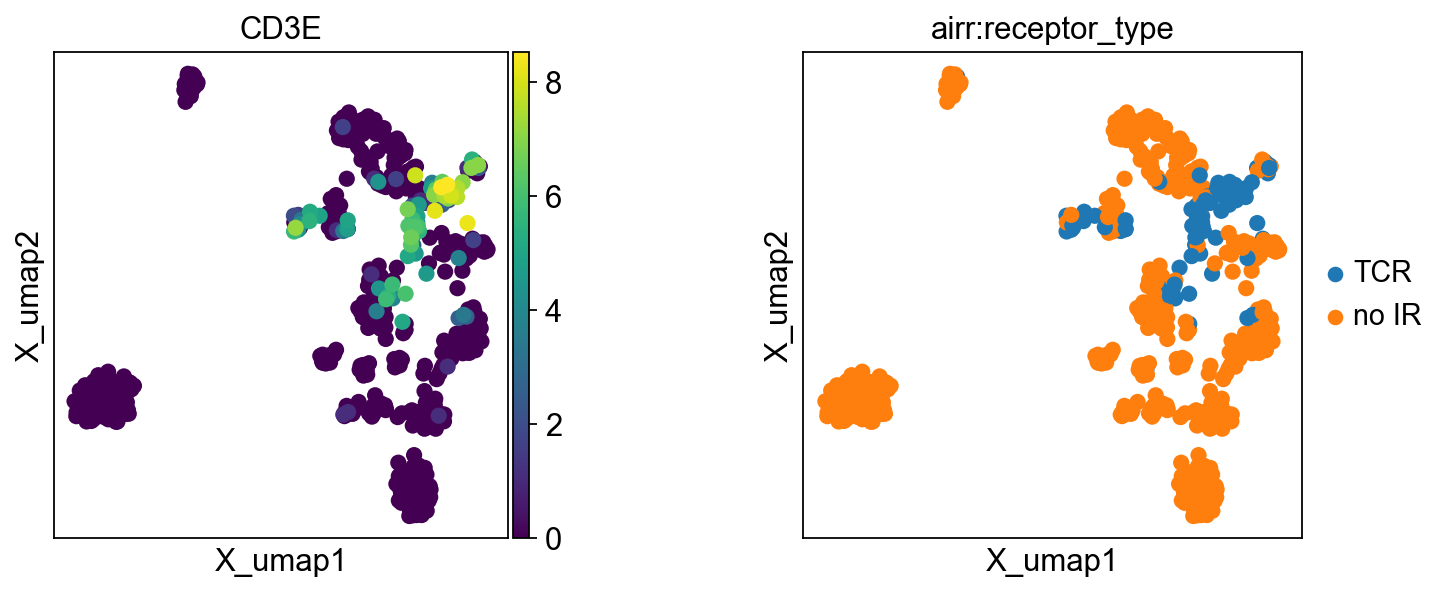

In [14]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={"wspace": 0.5})
mu.pl.embedding(mdata, basis="gex:umap", color=["CD3E"], ax=ax0, show=False)
mu.pl.embedding(mdata, basis="gex:umap", color=["airr:receptor_type"], ax=ax1)

In [15]:
adata = ir.io.read_airr(
    [
        "example_data/immunesim_airr/immunesim_tra.tsv",
        "example_data/immunesim_airr/immunesim_trb.tsv",
    ]
)
ir.pp.index_chains(adata)
ir.tl.chain_qc(adata)

  0%|          | 0/100 [00:00<?, ?it/s]

 27%|██▋       | 27/100 [00:00<00:00, 246.85it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 235.87it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 236.68it/s]

100%|██████████| 100/100 [00:00<00:00, 246.03it/s]

Stored result in `adata.obs["receptor_type"]`.


Stored result in `adata.obs["receptor_subtype"]`.


Stored result in `adata.obs["chain_pairing"]`.


In [16]:
ir.pp.ir_dist(adata, metric="alignment", sequence="aa", cutoff=25)

Computing sequence x sequence distance matrix for VJ sequences.


  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:22<00:44, 22.47s/it]

100%|██████████| 3/3 [00:22<00:00,  7.49s/it]

Computing sequence x sequence distance matrix for VDJ sequences.


  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:22<00:44, 22.36s/it]

100%|██████████| 3/3 [00:22<00:00,  7.45s/it]

Initializing lookup tables. 


Computing clonotype x clonotype distances.


  0%|          | 0/100 [00:00<?, ?it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 530.57it/s]

100%|██████████| 100/100 [00:00<00:00, 533.49it/s]

Stored result in `adata.obs["cc_aa_alignment"]`.


Stored result in `adata.obs["cc_aa_alignment_size"]`.


<Axes: title={'center': 'cc_aa_alignment'}>

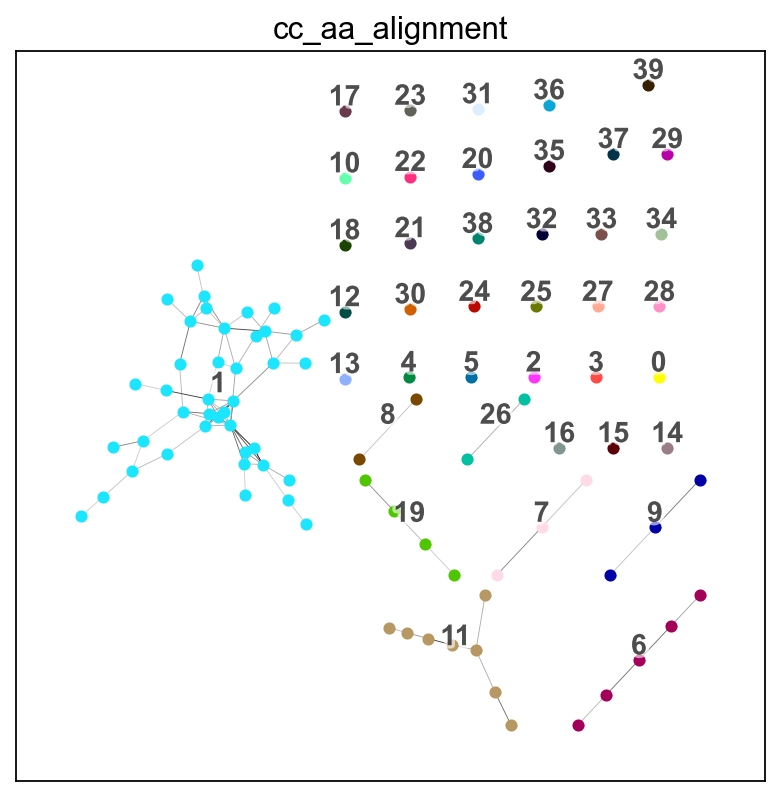

In [17]:
ir.tl.define_clonotype_clusters(
    adata,
    metric="alignment",
    sequence="aa",
    receptor_arms="any",
    dual_ir="primary_only",
)
ir.tl.clonotype_network(adata, size_aware=False, metric="alignment", sequence="aa")
ir.pl.clonotype_network(
    adata,
    color="cc_aa_alignment",
    base_size=20,
    panel_size=(6, 6),
    show_legend=False,
    show_size_legend=False,
)

In [18]:
tcr_table = pd.read_csv(
    "example_data/chung-park-2017/tcr_table.tsv",
    sep="\t",
    index_col=0,
    na_values=["None"],
    true_values=["True"],
)
tcr_table

,cell_id,cdr3_alpha,cdr3_nt_alpha,count_alpha,v_alpha,j_alpha,cdr3_beta,cdr3_nt_beta,count_beta,v_beta,d_beta,j_beta,productive_alpha,productive_beta
0,SRR2973278,AVSDIHASGGSYIPT,GCTGTTTCGGATATTCATGCATCAGGAGGAAGCTACATACCTACA,9.29463,TRAV21,TRAJ6,ASSWWQNTEAF,GCCAGCAGCTGGTGGCAGAACACTGAAGCTTTC,37.5984,TRBV5-1,NaN,TRBJ1-1,True,True
1,SRR2973305,AVVTGANSKLT,GCTGTGGTAACTGGAGCCAATAGTAAGCTGACA,89.45740,TRAV22,TRAJ56,NaN,NaN,NaN,NaN,NaN,NaN,True,True
2,SRR2973371,ALKRTGNTPLV,GCTCTGAAAAGAACAGGAAACACACCTCTTGTC,431.96500,TRAV9-2,TRAJ29,ASRSRDSGEPQH,GCCAGCAGGAGCAGGGACAGCGGAGAGCCCCAGCAT,952.0230,TRBV10-2,TRBD1,TRBJ1-5,True,True
3,SRR2973377,ATDPETSGSRLT,GCTACGGACCCAGAAACCAGTGGCTCTAGGTTGACC,772.43600,TRAV17,TRAJ58,NaN,NaN,NaN,NaN,NaN,NaN,True,True
4,SRR2973403,AVRGATDSWGKFQ,GCTGTGAGAGGAGCAACTGACAGCTGGGGGAAATTCCAG,95.63640,TRAV3,TRAJ24,SVQTSEYEQY,AGCGTCCAGACTAGCGAGTACGAGCAGTAC,205.8330,TRBV29-1,TRBD2,TRBJ2-7,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,SRR5023618,NaN,NaN,NaN,NaN,NaN,ASSDSPFSSYNEQF,GCCAGCAGTGACTCGCCCTTTAGCTCCTACAATGAGCAGTTC,864.4550,TRBV6-4,NaN,TRBJ2-1,True,True
86,SRR5023621,AENSGGSNYKLT,GCAGAGAATAGTGGAGGTAGCAACTATAAACTGACA,512.63000,TRAV13-2,TRAJ53,ASSPDGGGGYT,GCCAGCAGCCCTGATGGGGGAGGGGGCTACACC,805.2010,TRBV7-3,TRBD2,TRBJ1-2,True,True
87,SRR5023626,ALRIGSNYKLT,GCTCTGAGAATCGGTAGCAACTATAAACTGACA,12.51630,TRAV9-2,TRAJ53,NaN,NaN,NaN,NaN,NaN,NaN,True,True
88,SRR5023633,NaN,NaN,NaN,NaN,NaN,ASGLGQSVGGTQY,GCTAGTGGCCTAGGGCAGTCGGTAGGAGGGACCCAGTAC,18.4273,TRBV12-5,TRBD2,TRBJ2-5,True,True


In [19]:
tcr_cells = []
for _, row in tcr_table.iterrows():
    cell = ir.io.AirrCell(cell_id=row["cell_id"])
    # some fields are mandatory according to the Rearrangement standard, but can be set to NULL
    # the `empty_chain_dict()` function provides a dictionary with all mandatory fields, but set to NULL.
    alpha_chain = ir.io.AirrCell.empty_chain_dict()
    beta_chain = ir.io.AirrCell.empty_chain_dict()
    alpha_chain.update(
        {
            "locus": "TRA",
            "junction_aa": row["cdr3_alpha"],
            "junction": row["cdr3_nt_alpha"],
            "consensus_count": row["count_alpha"],
            "v_call": row["v_alpha"],
            "j_call": row["j_alpha"],
            "productive": row["productive_alpha"],
        }
    )
    beta_chain.update(
        {
            "locus": "TRB",
            "junction_aa": row["cdr3_beta"],
            "junction": row["cdr3_nt_beta"],
            "consensus_count": row["count_beta"],
            "v_call": row["v_beta"],
            "d_call": row["d_beta"],
            "j_call": row["j_beta"],
            "productive": row["productive_beta"],
        }
    )
    cell.add_chain(alpha_chain)
    cell.add_chain(beta_chain)
    tcr_cells.append(cell)

In [20]:
adata_tcr = ir.io.from_airr_cells(tcr_cells)

In [21]:
# We can re-use the transcriptomics data from above...
adata = sc.AnnData(expr_chung)
# ... and merge it with the TCR data
mdata = mu.MuData({"gex": adata, "airr": adata_tcr})

In [22]:
sc.pp.highly_variable_genes(mdata["gex"], flavor="cell_ranger", n_top_genes=3000)
sc.pp.log1p(mdata["gex"])
sc.pp.pca(mdata["gex"], svd_solver="arpack")
sc.pp.neighbors(mdata["gex"])
sc.tl.umap(mdata["gex"])
ir.pp.index_chains(mdata)
ir.tl.chain_qc(mdata)

If you pass `n_top_genes`, all cutoffs are ignored.


extracting highly variable genes


    finished (0:00:00)


computing PCA


    on highly variable genes


    with n_comps=50


    finished (0:00:00)


computing neighbors


    using 'X_pca' with n_pcs = 50


    finished (0:00:00)


computing UMAP


    finished (0:00:02)


  0%|          | 0/90 [00:00<?, ?it/s]

 42%|████▏     | 38/90 [00:00<00:00, 347.40it/s]

 84%|████████▍ | 76/90 [00:00<00:00, 347.29it/s]

100%|██████████| 90/90 [00:00<00:00, 359.98it/s]

Stored result in `mdata.obs["airr:receptor_type"]`.


Stored result in `mdata.obs["airr:receptor_subtype"]`.


Stored result in `mdata.obs["airr:chain_pairing"]`.


C:\hostedtoolcache\windows\Python\3.9.13\x64\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


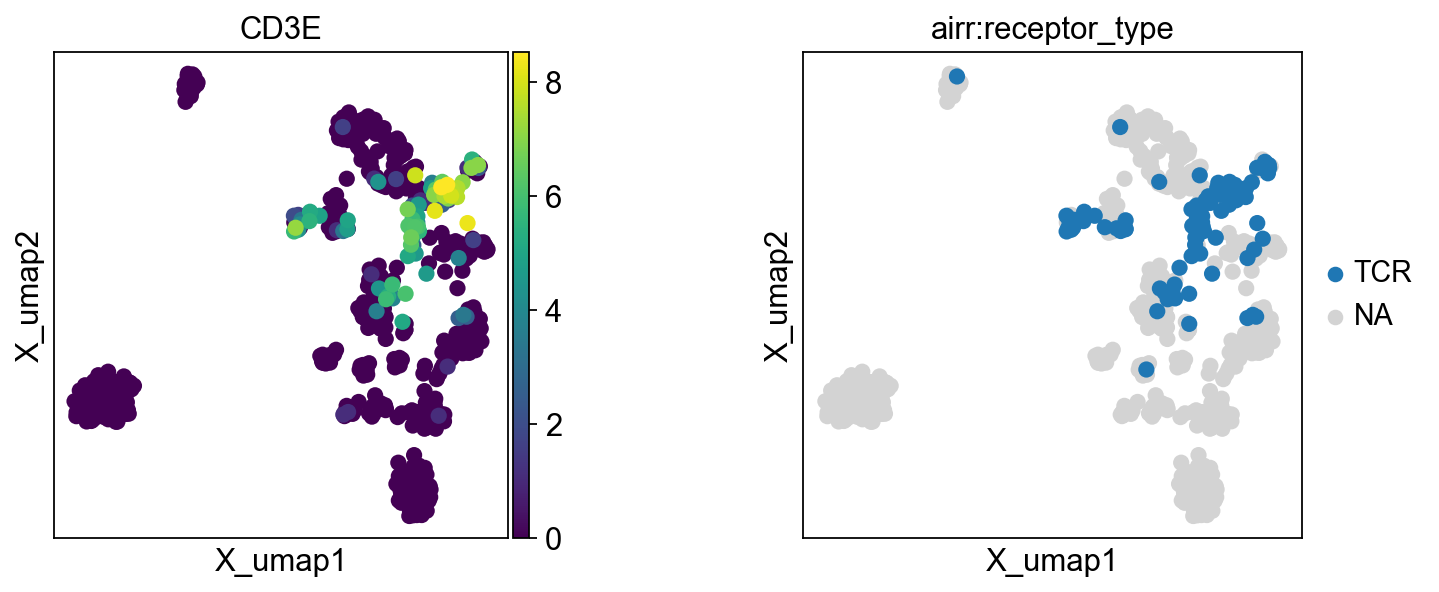

In [23]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={"wspace": 0.5})
mu.pl.embedding(mdata, basis="gex:umap", color=["CD3E"], ax=ax0, show=False)
mu.pl.embedding(mdata, basis="gex:umap", color=["airr:receptor_type"], ax=ax1)

In [24]:
# define sample metadata. Usually read from a file.
samples = {
    "C144": {"group": "mild"},
    "C146": {"group": "severe"},
    "C149": {"group": "healthy control"},
}

In [25]:
# Create a list of AnnData objects (one for each sample)
adatas_tcr = {}
adatas_gex = {}
for sample, sample_meta in samples.items():
    gex_file = glob(f"example_data/liao-2019-covid19/*{sample}*.h5")[0]
    tcr_file = glob(f"example_data/liao-2019-covid19/*{sample}*.csv.gz")[0]
    adata_gex = sc.read_10x_h5(gex_file)
    adata_tcr = ir.io.read_10x_vdj(tcr_file)
    # concatenation only works with unique gene names
    adata_gex.var_names_make_unique()
    adatas_tcr[sample] = adata_tcr
    adatas_gex[sample] = adata_gex

reading example_data/liao-2019-covid19\GSM4339772_C144_filtered_feature_bc_matrix.h5


 (0:00:00)


reading example_data/liao-2019-covid19\GSM4339774_C146_filtered_feature_bc_matrix.h5


C:\hostedtoolcache\windows\Python\3.9.13\x64\lib\site-packages\anndata\_core\anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:00)


reading example_data/liao-2019-covid19\GSM4475052_C149_filtered_feature_bc_matrix.h5


C:\hostedtoolcache\windows\Python\3.9.13\x64\lib\site-packages\anndata\_core\anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:00)


C:\hostedtoolcache\windows\Python\3.9.13\x64\lib\site-packages\anndata\_core\anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [26]:
# Merge anndata objects
adata_gex = anndata.concat(adatas_gex, index_unique="_")
adata_tcr = anndata.concat(adatas_tcr, index_unique="_")
mdata = mu.MuData({"gex": adata_gex, "airr": adata_tcr})

# Set global metadata on `mdata.obs`
mdata.obs["sample"] = mdata.obs_names.to_series().str.split("_", expand=True)[1]
mdata.obs["group"] = mdata.obs["sample"].map(lambda x: samples[x]["group"])

The data is now integrated in a single object.
Again, the detected TCRs coincide with `CD3E` gene expression.
We clearly observe batch effects between the samples -- for a meaningful downstream analysis further
processing steps such as highly-variable gene filtering and batch correction are necessary.

In [27]:
mdata

MuData object with n_obs × n_vars = 10715 × 33539
  obs:	'sample', 'group'
  2 modalities
    gex:	10706 x 33539
    airr:	581 x 0
      obsm:	'airr'

In [28]:
sc.pp.log1p(mdata["gex"])
sc.pp.pca(mdata["gex"], svd_solver="arpack")
sc.pp.neighbors(mdata["gex"])
sc.tl.umap(mdata["gex"])
ir.pp.index_chains(mdata)
ir.tl.chain_qc(mdata)

computing PCA


    with n_comps=50


    finished (0:00:07)


computing neighbors


    using 'X_pca' with n_pcs = 50


    finished (0:00:25)


computing UMAP


    finished (0:00:11)


  0%|          | 0/581 [00:00<?, ?it/s]

 11%|█▏        | 66/581 [00:00<00:00, 602.98it/s]

 24%|██▍       | 138/581 [00:00<00:00, 635.74it/s]

 37%|███▋      | 214/581 [00:00<00:00, 662.72it/s]

 50%|████▉     | 290/581 [00:00<00:00, 675.40it/s]

 64%|██████▎   | 369/581 [00:00<00:00, 691.74it/s]

 78%|███████▊  | 452/581 [00:00<00:00, 713.33it/s]

 91%|█████████▏| 531/581 [00:00<00:00, 716.25it/s]

100%|██████████| 581/581 [00:00<00:00, 700.89it/s]

Stored result in `mdata.obs["airr:receptor_type"]`.


Stored result in `mdata.obs["airr:receptor_subtype"]`.


Stored result in `mdata.obs["airr:chain_pairing"]`.


C:\hostedtoolcache\windows\Python\3.9.13\x64\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\hostedtoolcache\windows\Python\3.9.13\x64\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


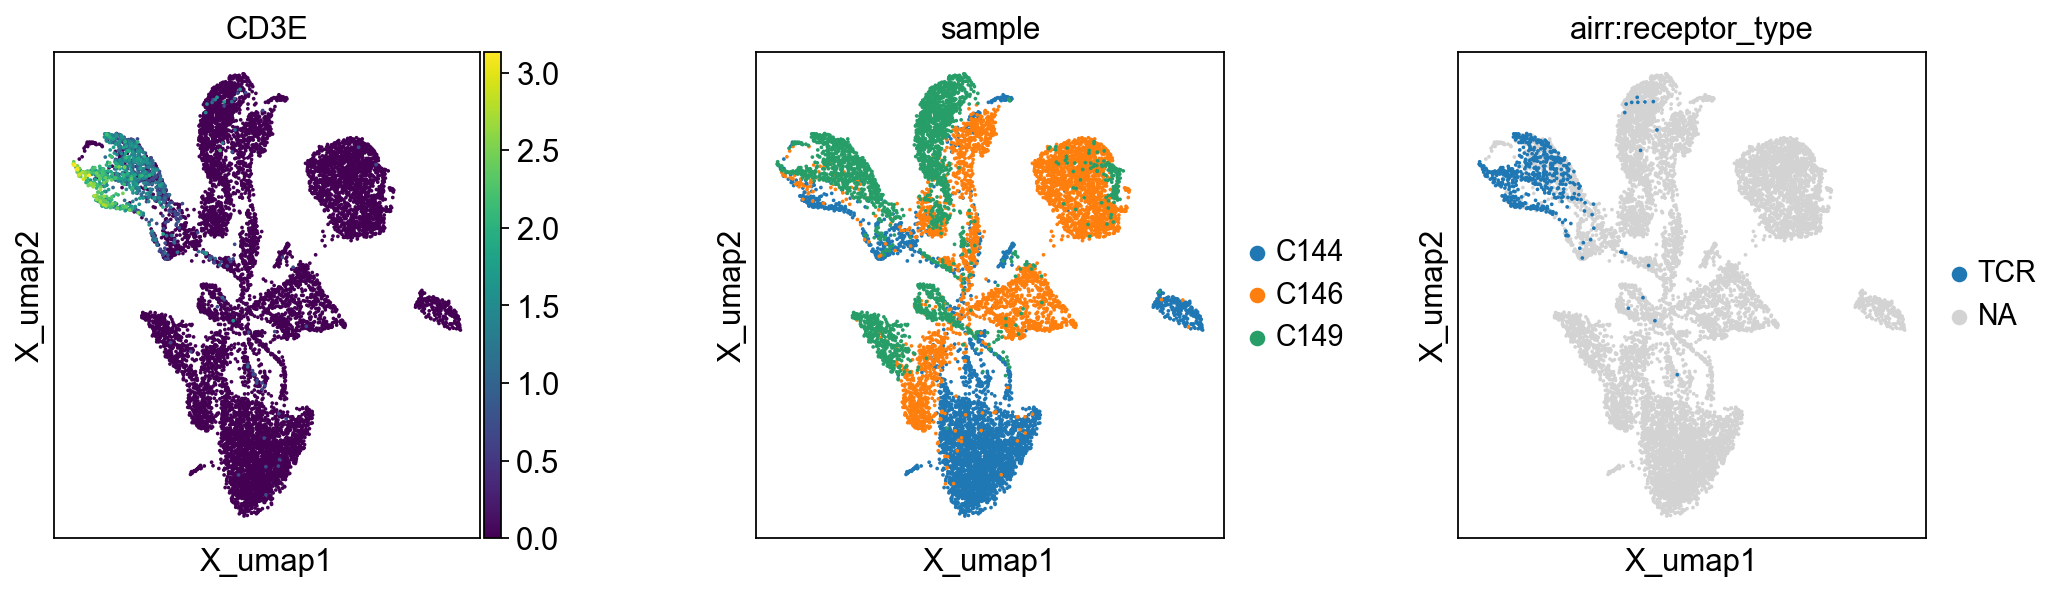

In [29]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 4), gridspec_kw={"wspace": 0.5})
mu.pl.embedding(mdata, basis="gex:umap", color="CD3E", ax=ax0, show=False)
mu.pl.embedding(mdata, basis="gex:umap", color="sample", ax=ax1, show=False)
mu.pl.embedding(mdata, basis="gex:umap", color="airr:receptor_type", ax=ax2)